# TOC

__Chapter 2 - Building blocks of neural networks__

1. [Import](#Import)
1. [Our first neural network](#Our-first-neural-network)
    1. [Data preparation](#Data-preparation)
    1. [Variables](#Variables)
    1. [Creating data for our neural network](#Creating-data-for-our-neural-network)
    1. [Creating learnable parameters](#Creating-learnable-parameters)
    1. [Network implementation](#Network-implementation)
    1. [Loss function](#Loss-function)
    1. [Optimize the neural network](#Optimize-the-neural-network)
    1. [Load data](#load-data)
        1. [Dataset class](#Dataset-class)
        1. [DataLoader class](#DataLoader-class)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from PIL import Image
from glob import glob
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# pytorch tools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# Our first neural network

This example revolves around a made-up company called Wondermovies, which serves videos on demand. The training data contains a feature that represents the average hours spent by users watching movies on the platform. We are attempting to predict how much time each user will spend on the platform the following week. Some of the high level activities include:

- __Data preparation__ - the get_data function prepares the tensors (arrays) containing input and output.
- __Creating learningable parameters__ - the get_weights function returns tensors with initially random values that will be optimized to solve out problem.
- __Network model__ - the simple_network function produces produces the output based on the input data by apply a linear rule, multiplying weights and the input data, and adding a bias term ($y = Wx + b$)
- __Loss__ - the loss_fn provides information on how well the model is performing
- __Optimizer__ - the optimize function adjusts the weights to help the model perform better.

```python
x, y = get_data()
w, b = get_weights()

for i in range(500):
    y_pred = simple_network(x)
    loss = loss_fun(y, y_pred)
    
if i % 50 == 0:
    print(loss)
    optimizer(learning_rate)
```

<a id = 'Our first-neural-network'></a>

## Data preparation

PyTorch provides two different types of data abstractions called tensors and variables. Tensors are similar to numpy array, and can be manipulated on GPUs.



<a id = 'Data-preparation'></a>

In [2]:
# scalar (0-D tensors) - PyTorch does not currently have a special tensor
# with zeor dimension, so below we have a one-dimension tensor with one element
x = torch.rand(1)
print(x.size())
print(x)

torch.Size([1])
tensor([0.9388])


In [3]:
# vectors (1-D tensors) - a vector is an array of elements
temp = torch.FloatTensor([23, 24, 24.5, 26, 27.2, 22.0])
print(temp)
print(temp.size())

tensor([23.0000, 24.0000, 24.5000, 26.0000, 27.2000, 22.0000])
torch.Size([6])


In [4]:
# matrices (2-D tensors) - a tensor representation of tabular data
from sklearn.datasets import load_boston, load_wine, load_iris, load_breast_cancer, make_blobs, make_moons

boston = load_boston()

boston_tensor = torch.from_numpy(boston.data)

print(boston_tensor[:5])
print(boston_tensor.size())

tensor([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01, 6.5750e+00,
         6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02, 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01, 6.4210e+00,
         7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02, 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01, 7.1850e+00,
         6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02, 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01, 6.9980e+00,
         4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02, 1.8700e+01, 3.9463e+02,
         2.9400e+00],
        [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01, 7.1470e+00,
         5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02, 1.8700e+01, 3.9690e+02,
         5.3300e+00]], dtype=torch.float64)
torch.Size([506, 13])


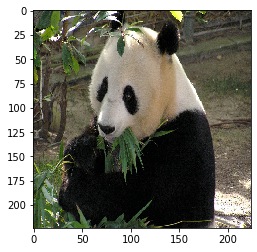

In [5]:
# 3-D tensors - the result of combing multiple 3-D tensors. These are often used to
# represent images. The three dimensions typically represent height, width, and color channel
panda = np.array(Image.open("s3://tdp-ml-datasets/misc/pandas.jpg").resize((224, 224)))
panda_tensor = torch.from_numpy(panda)
panda_tensor.size()

plt.imshow(panda)

tensor([1000.0000,  323.2000,  333.4000,  444.5000, 1000.0000])
tensor([1000.0000,  323.2000,  333.4000])


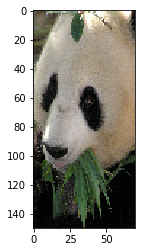

In [6]:
# slice tensors - PyTorch tensors can be slice in a manner similar to numpy arrays
sales = torch.FloatTensor([1000.0, 323.2, 333.4, 444.5, 1000.0, 323.2, 333.4, 444.5])

print(sales[:5])
print(sales[:-5])

# print panda image with only one color channel
plt.imshow(panda_tensor[:, :, 0].numpy())

# crop the panda image
plt.imshow(panda_tensor[25:175, 60:130, 0:].numpy())

## Variables

Deep learning algorithms are often represented as computation graphs, and nodes in the graph that hold data at a given state can be thought of as variables. In PyTorch, a variable is a wrapper around a tensor objects, its gradients and a reference to the function that created it. 

The autograd.Variable has three primary componenets - data, grad and creator. The data attribute simply access the tensor associated with the variable. The grad component includes the gradients, which describes rate of change of the loss function with respect to its parameters ($\textbf{W}, \textbf{b}$). For example, if the gradient of variable $\textbf{a}$ is 2, then any change in the value of $\textbf{a}$ would modify the value of $\textbf{Y}$ by two times. The creator component refers to the function that created the variable.

<a id = 'Variables'></a>

In [7]:
# create several variable and check the gradients and function
x = Variable(torch.ones(2, 2), requires_grad=True)
y = x.mean()

print("original tensor")
print(x)

# compute the gradients. By default, the gradients of variable are None
y.backward()

print("\ngradient")
print(x.grad)

# the grad_fn of the variable points to the function is created.
# if the variable is created by a user, like x, the function reference is None
print(x.grad_fn)

## here the grad_fn is associated with its function reference
print(y.grad_fn)

original tensor
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

gradient
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
None


## Creating data for our neural network

We need to create dummy data. These are fixed Variables and do not require a gradient.

<a id = 'Creating-data-for-our-neural-network'></a>

In [8]:
# functioin that creates our data
def get_data():
    train_X = np.asarray(
        [
            3.3,
            4.4,
            5.5,
            6.71,
            6.93,
            4.168,
            9.779,
            6.182,
            7.59,
            2.167,
            7.042,
            10.791,
            5.313,
            7.997,
            5.654,
            9.27,
            3.1,
        ]
    )
    train_Y = np.asarray(
        [
            1.7,
            2.76,
            2.09,
            3.19,
            1.694,
            1.573,
            3.366,
            2.596,
            2.53,
            1.221,
            2.827,
            3.465,
            1.65,
            2.904,
            2.42,
            2.94,
            1.3,
        ]
    )
    dtype = torch.FloatTensor
    X = Variable(torch.from_numpy(train_X).type(dtype), requires_grad=False).view(17, 1)
    y = Variable(torch.from_numpy(train_Y).type(dtype), requires_grad=False)
    return X, y

## Creating learnable parameters

We need to create two learnable parameters, w and b, to work alongside our fixed parameters, x and y. The learnable parameters require tha tthe require_Grad parameter is set to True.



<a id = 'Creating-learnable-parameters'></a>

In [9]:
#  function for creating randomly initialized
def get_weights():
    w = Variable(torch.randn(1), requires_grad=True)
    b = Variable(torch.randn(1), requires_grad=True)
    return w, b

## Network implementation

We need to perform matrix multiplication between x and w and add the bias b. This returns the predicted y. This can be performed in a custom function, and PyTorch also provides a higher-level abstraction in torch.nn called Layers. This takes care of most of the underlying processes.

<a id = 'Network-implementation '></a>

In [10]:
# custom-built function containing linear funciton
def simple_network(x):
    y_pred = torch.matmul(x, w) + b
    return y_pred

# built-in layer implementation
f = nn.Linear(17, 1)

## Loss function

We use predictions generated by our simple network function above to understand how close our model is to reality. To do this, we use a loss function called sum of squared error (SSE). The PyTorhc library has many different loss function available, but in this case we will create the loss function by hand.

In addition to the basic calculation of the loss, we also call the backward function, which calculates the gradients of the learnable parameters w and b, and we need to remove previously calculated gradient gradients when they exist. This operation is only skipped on the first loop of the function.

<a id = 'Loss-function'></a>

In [11]:
# custuom lost function
def loss_fn(y, y_pred):
    loss = (y_pred - y).pow(2).sum()
    for param in [w, b]:
        if not param.grad is None:
            param.grad.data.zero_()
    loss.backward()
    return loss.data.item()

## Optimize the neural network

We begin with randomized weights used to predict the targets for each sample. We use a loss function to calculate current performance, and call the backward function to calculate the gradients of the learnable parameters. This process of calculating predictions, loss and gradients repeats for a set number of iterations, and it most real-world implementation, we also perform an optimization step in each iteration. This optimization uses the gradients to change the weight values, such that the loss is reduced.

The optimization function multiplies the gradients, which denote the direction in which the parameters need to be adjusted, by a learning rate hyper-parameter, which controls the influence of the gradients.

<a id = 'Optimize-the-neural-network'></a>

In [12]:
# optimization function
def optimizer(learning_rate):
    w.data -= learning_rate * w.grad.data
    b.data -= learning_rate * b.grad.data

In [13]:
# first neural network
learning_rate = 0.00001

x, y = get_data()
w, b = get_weights()

for i in range(500):
    y_pred = simple_network(x)
    loss = loss_fn(y, y_pred)

    if i % 50 == 0:
        print(loss)
    optimizer(learning_rate)

459.453369140625
100.53057098388672
24.1470890045166
7.8893961906433105
4.426821708679199
3.6871275901794434
3.5268893241882324
3.4899768829345703
3.4793176651000977
3.4742591381073


## Load data

<a id = 'Load data'></a>

### Dataset class

Any custom dataset class created to work with PyTorch will take the following general form. The class needs to implement two main functions:

__len__(self) - returns the maximum number of elements in the dataset

__getitem(self, idx) - returns a specific element based on the idx

<a id = 'Dataset-class'></a>

In [14]:
# custom dataset class
from torch.utils.data import Dataset


class DogsAndCatsDataset(Dataset):
    def __init__(self,):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

In [15]:
# any required initialization occur inside the init method, for example if we are reading the index
# of the table and reading filenames of the images
class DogsAndCatsDataset(Dataset):
    def __init__(self, root_dir, size=(224, 224)):
        self.files = glob(root_dir)
        self.size = size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = np.asarray(Image.open(self.files(idx).resize(self.size)))
        label = self.files[idx].split("/")[-2]
        return img, label

### DataLoader class

In practice, the DataLoader class provides many efficiencies that allow neural networks to to learn from input data in batches. The DataLoader class combines a dataset object with different samples and provides batches of images, using either a single or multi-process iterators.

```python
#  dataloader class
dataloader = DataLoader(DogsAndCatsDataset, batch_size = 32, num_workers = 2)
for imgs, labels in dataloader():
    # apply deep learning process
    pass
```

imgs wil contain a tensor of shape (32, 224, 224, 3), where 32 represents the batch size which contains image that are of size 224 by 224 with 3 color channels.

The PyTorch ecosystem also includes torchvision and torch text, which utilize the Dataset and DataLoader classes.